# AS-AD in the Open Economy

**Goal.** Build a minimal open‑economy AS–AD notebook (same structure/level as the closed version) and compare **fixed** vs **flexible** exchange‑rate regimes.

We proceed in two steps:
1. **Static model.** Write down the equations, solve for the one‑period equilibrium, and plot AD, SRAS, LRAS for each regime.
2. **Dynamics.** Add simple shocks and adaptive expectations, then contrast impulse responses to **demand** vs **supply** shocks under fixed vs flexible exchange rates.


**Table of contents**<a id='toc0_'></a>    
- 1. [Small-open Economy](#toc1_)    
  - 1.1. [Flexible exchange rate](#toc1_1_)    
- 2. [Static comparison: fixed vs flexible exchange rate regime](#toc2_)    
    - 2.1.1. [Application 1: demand shift](#toc2_1_1_)    
    - 2.1.2. [Application 2: supply shift](#toc2_1_2_)    
- 3. [Dynamics and impulse responses](#toc3_)    
  - 3.1. [Demand Shock](#toc3_1_)    
  - 3.2. [Supply Shock](#toc3_2_)    
- 4. [Take Aways](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Small-open Economy](#toc0_)

Consider the following open economy AS–AD model.

**SRAS (short run):**
$$
\pi_t \;=\; \pi^{f} + \gamma\,(y_t-\bar y) + s_t,
$$
where $s_t$ is a supply shock.

**AD under a fixed exchange rate (peg):**
$$
y_t - \bar y \;=\; \beta_1\,(e_{-1}^r - \pi_t + \pi^f) + z_t,
$$
where $z_t$ captures demand shocks (foreign real rates, public spending, confidence, taxes).

**Real exchange rate evolution:**
$$
e_t^{r} \;=\; e_{t-1}^r + \pi^f - \pi_t.
$$
*(So the fixed-rate AD can also be written $y_t-\bar y=\beta_1 e_t^r+z_t$.)*

### 1.1. <a id='toc1_1_'></a>[Flexible exchange rate](#toc0_)

Use a reduced-form AD in $(\pi,y)$ that bundles IS + Taylor rule + ER channel:
$$
\pi_t \;=\; \pi^* \;-\; \frac{(y_t-\bar y) - z_t}{\alpha_{\text{flex}}}, 
\qquad 
\alpha_{\text{flex}} \;=\; \underbrace{\frac{b\,(a_1-1)}{1+b\,a_2}}_{\text{domestic policy}} \;+\; \underbrace{\alpha_{\text{er}}}_{\text{ER channel }(\ge 0)}.
$$
Equivalently,
$$
y_t-\bar y \;=\; z_t \;+\; \alpha_{\text{flex}}\,(\pi^* - \pi_t).
$$

**Notes:**
- Under a hard peg you can set $\alpha_{\text{er}}=0$ (no ER channel) and/or anchor SRAS with $\pi^f$ as above.  
- For the flexible case, $a_1>1$ is standard to ensure strong inflation response.


In [12]:
# -------------- Imports and baseline parameters ------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib defaults (cleaner plots)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Baseline parameters (same spirit as closed economy)
par = dict(
    # steady state
    ybar        = 1.0,
    pi_star     = 0.02,   # domestic target inflation
    pi_foreign  = 0.02,   # NEW: foreign inflation (used in SRAS anchor / ER law)

    # IS + Taylor (used in flexible-rate AD)
    b   = 0.6,
    a1  = 1.5,    # response to inflation gap (>1)
    a2  = 0.10,   # response to output gap

    # Phillips (SRAS)
    gamma = 0.4,

    # Openness / ER channel
    alpha_er = 0.50,  # extra AD stabilization when ER is flexible (0 under peg)
    beta1    = 0.50,  # NEW: AD sensitivity to real exchange rate under a peg

    # Shock dynamics (for dynamics section)
    delta   = 0.80,   # demand AR(1) persistence
    omega   = 0.15,   # supply AR(1) persistence
    sigma_x = 0.01,   # demand innovation std
    sigma_c = 0.005   # supply innovation std
)


In [13]:
# ---- Unchanged: domestic AD pieces used for the FLEXIBLE regime --------------
def ad_params_domestic(p):
    b, a1, a2 = p["b"], p["a1"], p["a2"]
    alpha_dom = b*(a1 - 1.0) / (1.0 + b*a2)
    z_scale   = 1.0 / (1.0 + b*a2)
    return alpha_dom, z_scale

# ---- AD curve for OPEN economy: FLEX vs FIXED --------------------------------
def ad_curve_open(y, p, v, regime="flex", e_r_prev=0.0):
    """
    Returns pi(y) on AD, given demand shock v and regime.
      FLEX:  pi = pi_star - ((y - ybar) - z_t) / alpha_open
      FIXED: pi = (e_{-1}^r + pi_foreign) - ((y - ybar) - z_t)/beta1
             using e_t^r = e_{-1}^r + pi_foreign - pi_t  => rearranged AD
    """
    ybar, pi_star = p["ybar"], p["pi_star"]
    if regime == "flex":
        alpha_dom, z_scale = ad_params_domestic(p)
        z_t = v * z_scale
        alpha_open = alpha_dom + p.get("alpha_er", 0.0)
        if alpha_open <= 1e-12:
            alpha_open = 1e-12
        return pi_star - ((y - ybar) - z_t) / alpha_open
    else:  # "fixed"
        beta1 = p["beta1"]
        z_t   = v  # simplest: treat v as the AD level shock directly under a peg
        return (e_r_prev + p["pi_foreign"]) - ((y - ybar) - z_t) / beta1

# ---- SRAS (keep as-is; choose pi_e in the caller) ----------------------------
def sras_curve(y, p, pi_e, s):
    return pi_e + p["gamma"]*(y - p["ybar"]) + s


In [14]:
def solve_grid(pi_e=None, v=0.0, s=0.0, p=par, pad=0.6, n=600, regime="flex", e_r_prev=0.0):
    """
    Find (y*, pi*) with linear interpolation where AD(y)=SRAS(y).
    For FIXED regime, pass the state e_r_prev. If pi_e is None:
        - FIXED:  pi_e = p["pi_foreign"]  (matches your SRAS markdown)
        - FLEX:   pi_e = p["pi_star"]     (neutral baseline)
    """
    if pi_e is None:
        pi_e = p["pi_foreign"] if regime == "fixed" else p["pi_star"]

    y = np.linspace(p["ybar"] - pad, p["ybar"] + pad, n)
    pi_ad   = ad_curve_open(y, p, v, regime=regime, e_r_prev=e_r_prev)
    pi_sras = sras_curve(y, p, pi_e, s)
    diff = pi_ad - pi_sras

    idx = np.where(diff[:-1]*diff[1:] <= 0)[0]
    if len(idx):
        i = idx[0]
        w = diff[i] / (diff[i] - diff[i+1] + 1e-16)
        y_star  = y[i] + w*(y[i+1] - y[i])
        pi_star = pi_ad[i] + w*(pi_ad[i+1] - pi_ad[i])
    else:
        i = int(np.argmin(np.abs(diff)))
        y_star, pi_star = y[i], pi_sras[i]
    return float(y_star), float(pi_star), y, pi_ad, pi_sras

## 2. <a id='toc2_'></a>[Static comparison: fixed vs flexible exchange rate regime](#toc0_)

We hold $(pi^e, v, s)$ fixed and plot AD, SRAS, and LRAS under both regimes, marking the equilibria.


In [15]:
# -------------- Static plot function -----------------------------------------
def plot_static_open(pi_e=0.02, v=0.0, s=0.0, p=par, pad=0.6):
    ybar = p["ybar"]
    # Solve once per regime (same grid width for visual comparability)
    y_fix, pi_fix, ygrid, pi_ad_fix,  pi_sras_fix  = solve_grid(pi_e, v, s, p, pad, regime="fixed")
    y_flex,pi_flex,_,     pi_ad_flex, pi_sras_flex = solve_grid(pi_e, v, s, p, pad, regime="flex")

    fig, ax = plt.subplots(figsize=(6.6,4.6))
    # Curves
    ax.plot(ygrid, pi_ad_fix,  ls="--",  color="#8c564b", label="AD (fixed)")
    ax.plot(ygrid, pi_ad_flex, ls="--",  color="#1f77b4", label="AD (flex)")
    ax.plot(ygrid, pi_sras_fix, ls="-",  color="#2ca02c", label="SRAS")
    # LRAS
    ax.axvline(ybar, color="k", ls=":", lw=1.2, label="LRAS")
    # Equilibria
    ax.scatter([y_fix],[pi_fix],   color="#8c564b", edgecolor="k", zorder=5, label="Eq (fixed)")
    ax.scatter([y_flex],[pi_flex], color="#1f77b4", edgecolor="k", zorder=5, label="Eq (flex)")
    ax.set_xlabel("y"); ax.set_ylabel("pi"); ax.set_title("Static AS–AD: fixed vs flexible")
    ax.legend(loc="best", frameon=True)
    plt.tight_layout(); plt.show()



#### 2.1.1. <a id='toc2_1_1_'></a>[Application 1: demand shift](#toc0_)

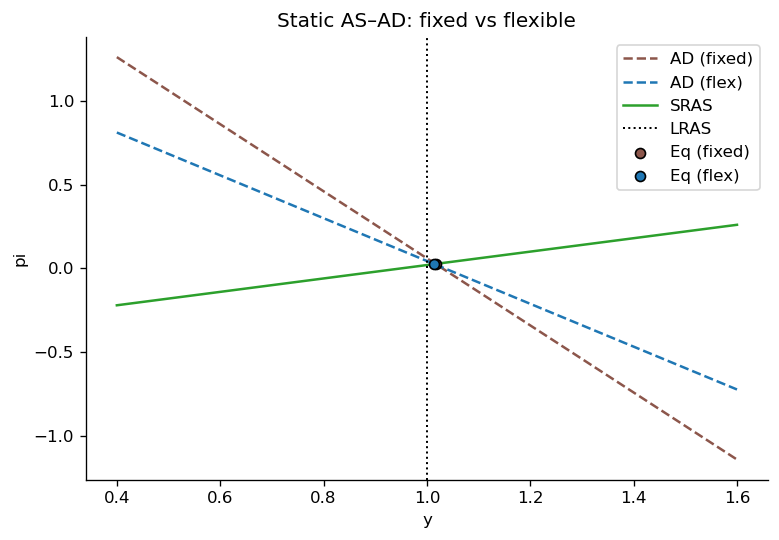

In [16]:
plot_static_open(pi_e=0.02, v=0.02, s=0.00, p=par, pad=0.6)

#### 2.1.2. <a id='toc2_1_2_'></a>[Application 2: supply shift](#toc0_)

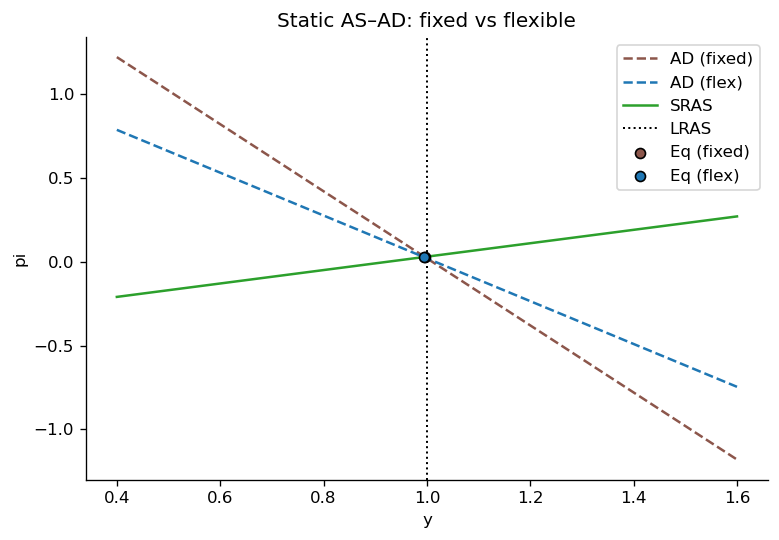

In [17]:
plot_static_open(pi_e=0.02, v=0.00, s=0.01, p=par, pad=0.6)

## 3. <a id='toc3_'></a>[Dynamics and impulse responses](#toc0_)

- **Expectations:** $\pi_t^{e} = \pi_{t-1}$ (adaptive).  
- **Shocks:** AR(1) for demand $v_t$ and supply $s_t$, or a one‑time impulse.  
- **Each period:** find $(y_t,\pi_t)$ by solving the static intersection with the current $(\pi_t^e, v_t, s_t)$.

We compare **fixed** vs **flexible** regimes by simulating the **same shocks** under both.


In [18]:
# -------------- Shock generator and simulation per regime --------------------
def ar1_series(T, rho, sigma, seed=None, shock0=0.0):
    rng = np.random.default_rng(seed)
    e = rng.normal(0.0, sigma, size=T)
    x = np.empty(T); x[0] = shock0
    for t in range(1, T):
        x[t] = rho*x[t-1] + e[t]
    return x

def simulate_open(T=60, p=par, mode="impulse", which="demand", size=0.2,
                  regime="flex", pad=0.6, n=600, seed=1):
    """
    Simulate paths under a given regime using grid-based static equilibrium each period.
    mode: "impulse" or "stochastic"
    which (if impulse): "demand" or "supply"
    """
    T = int(T)
    # Build shocks
    if mode == "stochastic":
        v = ar1_series(T, p["delta"], p["sigma_x"], seed=seed,   shock0=0.0)
        s = ar1_series(T, p["omega"], p["sigma_c"], seed=seed+1, shock0=0.0)
    else:
        v = np.zeros(T); s = np.zeros(T)
        if which == "demand":
            v[0] = size
        else:
            s[0] = size
        for t in range(1, T):
            v[t] = p["delta"]*v[t-1]
            s[t] = p["omega"]*s[t-1]

    # Containers
    y  = np.empty(T); pi = np.empty(T); pi_e = np.empty(T)
    pi_prev = p["pi_star"]
    for t in range(T):
        pi_e[t] = pi_prev
        y[t], pi[t], *_ = solve_grid(pi_e=pi_e[t], v=v[t], s=s[t], p=p, pad=pad, n=n, regime=regime)
        pi_prev = pi[t]

    return {"y": y, "pi": pi, "v": v, "s": s, "pi_e": pi_e, "regime": regime, "par": p}


In [19]:
# -------------- Overlay IRFs: fixed vs flexible ------------------------------
def plot_irfs_compare(res_fix, res_flex, title_suffix=""):
    p = res_fix["par"]
    # Inflation
    plt.figure(figsize=(6.6,3.6))
    plt.plot(res_fix["pi"],  label="fixed",  lw=2, color="#8c564b")
    plt.plot(res_flex["pi"], label="flex",   lw=2, color="#1f77b4")
    plt.axhline(p["pi_star"], ls="--", c="k", lw=1)
    plt.title(f"Inflation path {title_suffix}")
    plt.xlabel("t"); plt.ylabel("pi"); plt.legend(); plt.tight_layout(); plt.show()

    # Output
    plt.figure(figsize=(6.6,3.6))
    plt.plot(res_fix["y"],  label="fixed",  lw=2, color="#8c564b")
    plt.plot(res_flex["y"], label="flex",   lw=2, color="#1f77b4")
    plt.axhline(p["ybar"], ls="--", c="k", lw=1)
    plt.title(f"Output path {title_suffix}")
    plt.xlabel("t"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()


### 3.1. <a id='toc3_1_'></a>[Demand Shock](#toc0_)

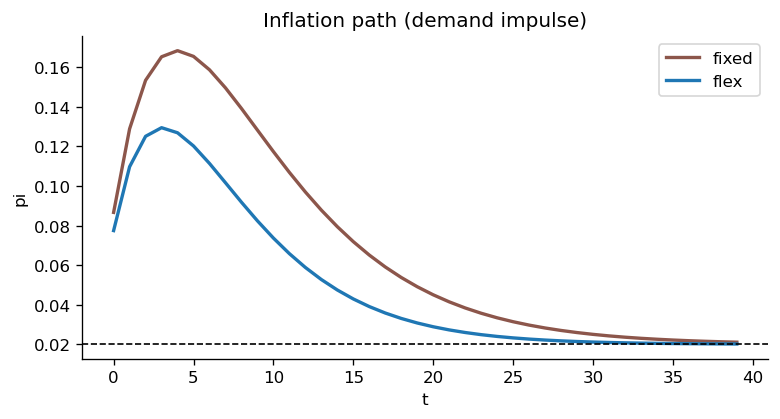

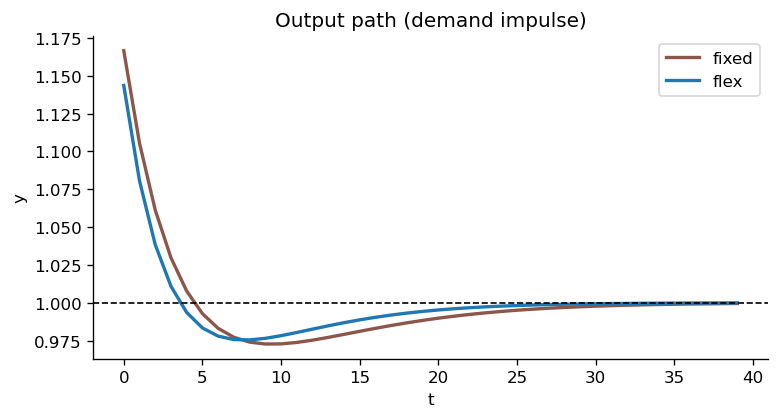

In [22]:
# Demand impulse (flex typically dampens via ER channel)
res_fix_d  = simulate_open(T=40, p=par, mode="impulse", which="demand", size=0.2,  regime="fixed", pad=0.6, n=800)
res_flex_d = simulate_open(T=40, p=par, mode="impulse", which="demand", size=0.2,  regime="flex",  pad=0.6, n=800)
plot_irfs_compare(res_fix_d, res_flex_d, "(demand impulse)")


### 3.2. <a id='toc3_2_'></a>[Supply Shock](#toc0_)

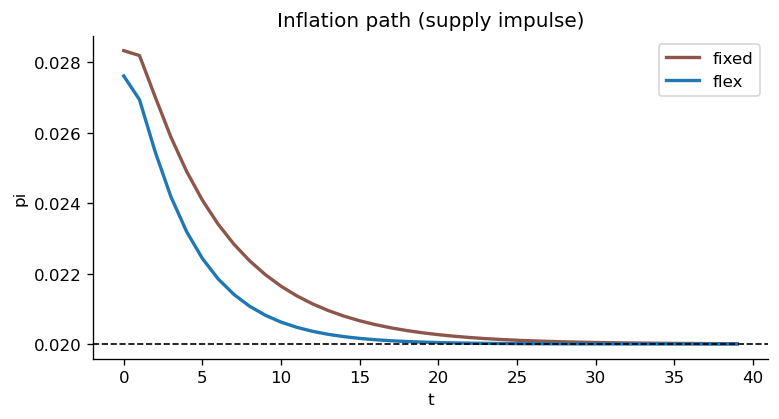

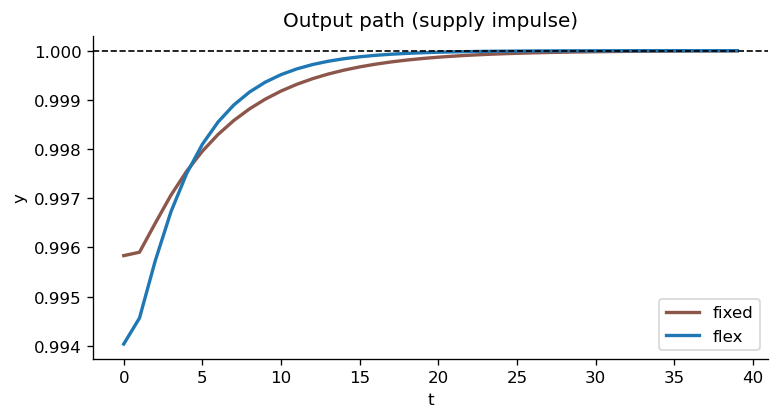

In [21]:

# Supply impulse (cost‑push)
res_fix_s  = simulate_open(T=40, p=par, mode="impulse", which="supply", size=0.01, regime="fixed", pad=0.6, n=800)
res_flex_s = simulate_open(T=40, p=par, mode="impulse", which="supply", size=0.01, regime="flex",  pad=0.6, n=800)
plot_irfs_compare(res_fix_s, res_flex_s, "(supply impulse)")

## 4. <a id='toc4_'></a>[Take Aways](#toc0_)

- We extended the closed economy framework to the small-open economy and compared the fixed vs. flexible exchange rate regime.
- **Static comparison.** We write AD–SRAS–LRAS for a small open economy and solve the one-period equilibrium under **fixed** vs **flexible** exchange rates. Under the peg, AD uses the real exchange rate state $e_{t-1}^r$; under flexible exchange rates, AD is steeper.
- **Dynamic paths.** We add adaptive expectations $\,\pi_t^e=\pi_{t-1}\,$ and evolve the real exchange rate via $\,e_t^r=e_{t-1}^r+\pi^f-\pi_t\,$ (peg). We simulate **demand** and **supply** shocks and contrast impulse responses across regimes.
- **Programming patterns.** We keep the same grid-based solver and just pass a `regime` flag and (for the peg) the state $e_{t-1}^r$. We reuse one shock draw for both regimes and expose behavior through a few parameters.